# Super Mario Bros Gym challenge
This is the example notebook for the seminar:

392241 Applied Cognitive Computing: Deep reinforcement learning with bounded rationality

# Setup

In [ ]:
! pip index versions pytorch

In [ ]:
! pip cache purge

In [ ]:
! pip uninstall gym --yes

In [ ]:

#! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
! pip install gym-super-mario-bros opencv-python numpy tqdm --no-cache-dir
! pip install mediapy scipy --no-cache-dir
! pip install gym --no-cache-dir


## Checking the gpu that is provided by google colab.
If you don't see a gpu listed, or an error is shown, please click on the small dropdown arrow on the top right corner and choose "View Ressources" from the appearing menu.

From there you can click on "Change runtime type" on the bottom right.

In the appearing window, you should be able to select a "Hardware accelerator", which you will have to set to "GPU"

In [ ]:
! nvidia-smi

Mon Jun 12 09:53:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     5W /  N/A |      0MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PPO Algorithm

Here we define the PPO Algorithm, that can be freely extended during the seminar.

The imports used for the PPO algorithm

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT, RIGHT_ONLY
from datetime import datetime
import cv2
from tqdm import tqdm
import numpy as np
from gym.wrappers import GrayScaleObservation

Setting the device to gpu if available

In [ ]:
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))

else:
    print("Device set to : cpu")
    raise ValueError("No GPU is set")

Device set to : NVIDIA GeForce GTX 1060


## ActorCritic
Here we define the actor critic agent that functions as our neural network.
To get a better understanding of the algorithm you can take a look at: https://theaisummer.com/Actor_critics/

## RolloutBuffer

In [ ]:
# The RolloutBuffer which keeps the training tuples.
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    # We clear the buffer after each training update
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # We define if the action space is continuous or a value choosen from a set of possible actions
        self.has_continuous_action_space = has_continuous_action_space


        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # defining the actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=8, stride=4, padding=0),
                            #nn.ReLU(),
                            nn.Tanh(),
                            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=0),
                            #nn.ReLU(),
                            nn.Tanh(),
                            Reshape(-1,288),
                            nn.Linear(288, 256),
                            #nn.ReLU(),
                            nn.Tanh(),
                            #nn.ReLU(),
                            nn.Linear(256, action_dim)
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=8, stride=4, padding=0),
                            #nn.ReLU(),
                            nn.Tanh(),
                            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=0),
                            #nn.ReLU(),
                            nn.Tanh(),
                            Reshape(-1,288),
                            nn.Linear(288, 256),
                            #nn.ReLU(),
                            nn.Tanh(),
                            #nn.ReLU(),
                            nn.Linear(256, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # defining the critic
        self.critic = nn.Sequential(
                        nn.Conv2d(in_channels=4, out_channels=4, kernel_size=8, stride=4, padding=0),
                        #nn.ReLU(),
                        nn.Tanh(),
                        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=0),
                        #nn.ReLU(),
                        nn.Tanh(),
                        Reshape(-1,288),
                        nn.Linear(288, 256),
                        #nn.ReLU(),
                        nn.Tanh(),
                        #nn.ReLU(),
                        nn.Linear(256, 1)
                    )

    def set_action_std(self, new_action_std):
        #We only calculate the action std if we have a continuous action space
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        # if we have a continuous action space we sample from a multivariate normal distribution
        # otherwise we calculate a categorical action spac
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)

            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


##PPO

In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

##Helper Functions for the environments and rendering

In [ ]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//6)

#plot for visualizing results
def plotRewardandTime(avg_reward,avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  import scipy
  from scipy.signal import savgol_filter
  x = np.linspace(0,len(avg_reward),len(avg_reward))

  fig, axs = plt.subplots(2, 2,figsize=(9,9))
  axs[0, 0].plot(x, savgol_filter(avg_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_reward) > 30 else avg_reward)
  axs[0, 0].set_title("avg_reward")

  axs[0, 1].plot(x, savgol_filter(avg_norm_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_norm_reward) > 30 else avg_norm_reward)
  axs[0, 1].set_title("avg_norm_reward")

  axs[1, 0].plot(x, savgol_filter(avg_length,window_length=29,polyorder=3,mode='mirror') if len(avg_length) > 30 else avg_length)
  axs[1, 0].set_title("avg_length")
  plt.show()

In [ ]:
# had to adjust code in time_limit.py to run on local machine: https://stackoverflow.com/questions/74060371/gym-super-mario-bros-7-3-0-valueerror-not-enough-values-to-unpack-expected
import gym

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=10):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']

        if self.count >= self.threshold:
            #reward = -100
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)



#Training

--------------------------------
Epoch 10000 done:
Update iterations: 540
Statistics:

Reward for this episode: 360.83333333333326
Length of this episode: 198

Average total reward: 264.25166666666667
Average normalized reward: 2.003225660111496
Average length: 130.36
--------------------------------


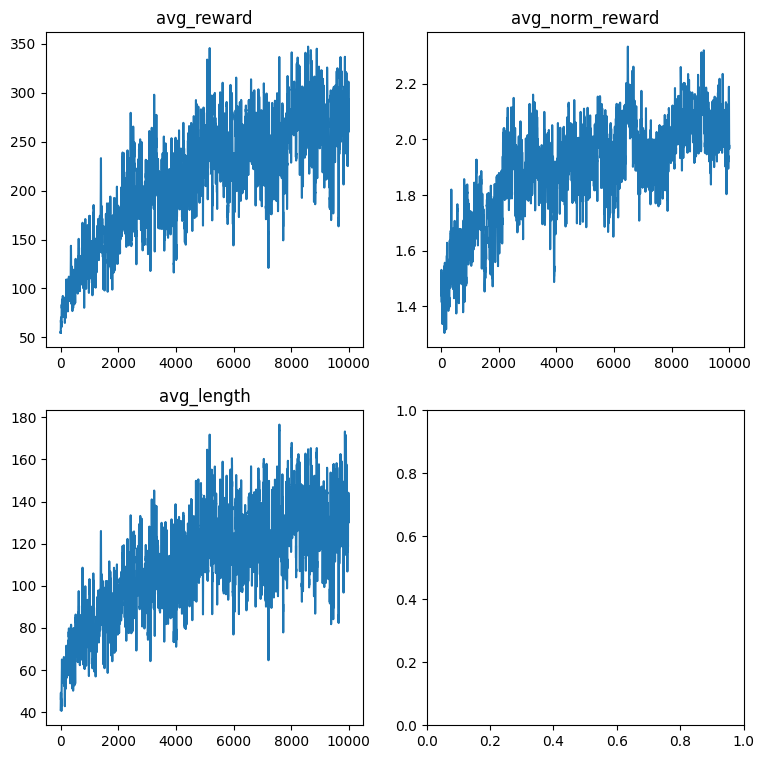

timestep: 1106817 updates: 540 reward: 2.0115778486636846: 100%|██████████████| 10001/10001 [4:56:06<00:00,  1.78s/it]


In [ ]:
from IPython.core.display import clear_output



state_dim = 15360                     # state space dimension
lr_actor = 0.0003                     # learning rate for actor network
lr_critic = 0.001                     # learning rate for critic network
gamma = 0.99                          # gamma discount
#gamma = 0.9
K_epochs = 40                         # K value for the PPO-CLIP objective function
eps_clip = 0.2                        # the epsilon clipping value
has_continuous_action_space = False   # the mario environment doesn't have a continuous action space
action_std = None                     # we don't change the action distribution
#frameskip = 4
frameskip = 6                         # the frameskip value of the environment
down_sample_rate = 4                  # downsample rate. Calculated as: original_dimension/down_sample_rate
frame_stack = 4                       # frame stacking value
update_steps = 2048                   # how long we collect steps before updating
x_dim = 64
y_dim = 60

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')  #the environment. v0 is with original background, v1 has the background removed
#env = JoypadSpace(env, COMPLEX_MOVEMENT)              #The Joypadspace sets the available actions. We use COMPLEX_MOVEMENT to allow to go down in pipes.
env = JoypadSpace(env, RIGHT_ONLY)              #The Joypadspace sets the available actions. We use COMPLEX_MOVEMENT to allow to go down in pipes.
env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
#env = DeadlockEnv(env,threshold=50)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe
env = DeadlockEnv(env,threshold=10)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe


action_dim = env.action_space.n # action space dimension
#state_dim = env.state_space.n  # Currently we flatten the input and therefore set the state_dim manually

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")

#some helper variables
time_step = 0
#max_training_epochs = int(1e9)
max_training_epochs = 10000
max_ep_len = 10000
update_timestep = max_ep_len

# We mount the google drive to save and load PPO states.
from google.colab import drive
drive.mount('/content/gdrive')

# If an agent is saved you can uncomment the following line to load the weights.
#ppo_agent.load("/content/gdrive/My Drive/ppo.save")

avg_reward = []
avg_length = []
avg_norm_reward = []
updates = 0

tbar = tqdm(range(max_training_epochs + 1))
for i in tbar:
    # first we reset the state
    state = env.reset()
    current_ep_reward = 0
    # as we stack some frames, we create a buffer with empty frames for the first inputs
    states_buffer = [np.zeros((x_dim,y_dim)) for _ in range(3)]
    #states_buffer = [np.zeros((3840,)) for _ in range(3)]
    frames = []
    # the collection loop
    for t in range(1, max_ep_len):
        # Downsampling the environment
        #in_state = GrayScale(Downsample(down_sample_rate,state.copy())).flatten()
        in_state = GrayScale(Downsample(down_sample_rate,state.copy()))

        # creating the new stack for the current frame
        states_buffer.append(in_state)
        states_buffer = states_buffer[-frame_stack:]

        # selecting an action
        action = ppo_agent.select_action(np.asarray(states_buffer).reshape((1,4,x_dim,y_dim)))
        #action = ppo_agent.select_action(np.asarray(states_buffer).flatten())

        # performing the action and receiving the information from the environments
        state, reward, done, _ = env.step(action)

        # Addition: punish deaths more harshly
        #if reward == -15:
        #    reward = -100

        # Every 50 epochs we render the environments and therefore save the state
        if i % 50 == 0 and not done:
            frames.append(state.copy())

        # The PPO agent needs the reward and the done state manually, as we could modify it.
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # every update_steps (2048) we update the algorithm
        if time_step % update_steps == 0:
            ppo_agent.update()
            updates += 1

        # if the run is done we break the loop
        if done:
            break

    # We collect information every run and write them to the console
    avg_reward.append(current_ep_reward)
    avg_length.append(t)
    tbar.set_description("timestep: " + str(time_step) + " updates: "+str(updates)+" reward: "+str(np.asarray(avg_norm_reward[-50:]).mean()))
    avg_norm_reward.append(current_ep_reward/max(1,t))

    # Every 50 epochs we render the current environment
    if i % 50 == 0 and len(frames) > 0:
      clear_output(wait=True)
      print("--------------------------------")
      print("Epoch",i,"done:")
      print("Update iterations:",updates)
      print("Statistics:")
      print("")
      print("Reward for this episode:",current_ep_reward)
      print("Length of this episode:",t)
      print("")
      print("Average total reward:",np.asarray(avg_reward[-50:]).mean())
      print("Average normalized reward:",np.asarray(avg_norm_reward[-50:]).mean())
      print("Average length:",np.asarray(avg_length[-50:]).mean())
      print("--------------------------------")
      plotRewardandTime(avg_reward,avg_norm_reward,avg_length)
      renderEnv(frames)
      # We DONT save the first epoch, as that would be just random weights.
      if i > 10:
        ppo_agent.save("/content/gdrive/My Drive/ppo.save")







env.close()